<a href="https://colab.research.google.com/github/datamonsterr/20million_vehicle_detection/blob/main/Data_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub
datapath = kagglehub.dataset_download('thanhtuyen04/linkdata')

100%|██████████| 668M/668M [00:13<00:00, 50.4MB/s]

Extracting files...


In [ ]:
kaggle = datapath
trainpath = f"{kaggle}/train_20241023"
ptestpath = f"{kaggle}/public test/public test"
classes = ["motorbike", "car", "bus", "container"]
SEED = 17
day = f"{trainpath}/daytime"
night = f"{trainpath}/nighttime"
REASSIGN_LABEL = True # Assign night class to be same as day

In [ ]:
import torch
import torchvision
import numpy as np
from PIL import Image
import cv2
import torchvision.transforms.v2 as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
import os
import matplotlib.pyplot as plt

In [ ]:
annotation_paths = {'day': [], 'night': []}
img_paths = {'day': [], 'night': []}
for t in ['day', 'night']:
    for root, dirs, files in os.walk(f"{trainpath}/{t}time"):
        for file in files:
            if file.endswith(".jpg"):
                if os.path.exists(os.path.join(root, file.replace(".jpg", ".txt"))):
                    img_paths[t].append(os.path.join(root,file))
                    annotation_paths[t].append(os.path.join(root, file.replace(".jpg", ".txt")))
print(len(annotation_paths['day']), len(annotation_paths['night']))
print(len(img_paths['day']), len(annotation_paths['night']))
img_height, img_width, _ = cv2.imread(img_paths['day'][1]).shape
img_height, img_width

6891 4629
6891 4629


(720, 1280)

In [ ]:
def read_annotation(annotation_path):
    with open(annotation_path, 'r') as f:
        lines = f.readlines()
        ann = []
        for line in lines:
            line = line.strip().split(' ')
            class_id = int(line[0])
            x_center = float(line[1])
            y_center = float(line[2])
            width = float(line[3])
            height = float(line[4])

            # Relabel nighttime class -> daytime
            if REASSIGN_LABEL and class_id >= 4:
                class_id -= 4
            ann.append([class_id, x_center, y_center, width, height])
        return ann

annotations= {'day': [], 'night': []}
for t in ['day', 'night']:
  annotations[t] = [0] * len(annotation_paths[t])
  for i in range(len(annotation_paths[t])):
    annotations[t][i] = read_annotation(annotation_paths[t][i])

In [ ]:
def yolo_to_normal(x_center, y_center, width, height, img_w, img_h):
    xmin = (x_center - width / 2) * img_w
    ymin = (y_center - height / 2) * img_h
    xmax = (x_center + width / 2) * img_w
    ymax = (y_center + height / 2) * img_h
    return xmin, ymin, xmax, ymax

def normal_to_yolo(xmin, ymin, xmax, ymax, img_w, img_h):
    x_center = (xmin + xmax) / (2 * img_w)
    y_center = (ymin + ymax) / (2 * img_h)
    width = (xmax - xmin) / img_w
    height = (ymax - ymin) / img_h
    return x_center, y_center, width, height

def img_box(img_path, ann):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_height, img_width, _ = img.shape

    for bbox in ann:
        label, xcen, ycen, w, h = bbox
        x1, y1, x2, y2 = np.int32(np.round(yolo_to_normal(xcen, ycen, w, h, img_width, img_height), decimals=-1))
        cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0),4)

        text = f"{classes[label]}"
        text_size, _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 1, 2)
        text_width, text_height = text_size
        cv2.putText(img, text, (x1, y1 - 10), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0,255, 0), 2)

    return img

In [ ]:
from torchvision.transforms.v2 import functional as F

img_transform = transforms.Compose([
   transforms.ToImage(),
   transforms.GaussianNoise(mean=0.3),
   transforms.ColorJitter(brightness=[0.3, 0.5], saturation=[0.7, 1], contrast=[0.7, 1]),
   transforms.ToDtype(torch.float32, scale=True)
])

def random_light(img, target):
    # Convert tensor to numpy and permute dimensions for OpenCV compatibility
    img = F.to_image(img).permute(1, 2, 0).numpy()
    h,w,c= img.shape
    # Extract bounding boxes and labels from the target
    boxes = target['boxes']
    labels = target['labels']

    # Circle parameters
    alpha = 0.1
    color = (200, 50, 0)
    radius = 30
    # Initialize circle mask with the same shape as img
    circle_mask = np.zeros(img.shape, dtype=np.uint8)

    for bbox, label in zip(boxes, labels):
        xmin, ymin, xmax, ymax = bbox
        ratio = (ymax - ymin) / h
        if xmax - xmin > 1.5*(ymax - ymin):
          continue
        if label == 1:
            r = np.int32(radius *ratio)
            # Calculate center for label 1
            x, y = np.int32([xmin + (xmax - xmin) / 2, ymin + (0.7 * (ymax - ymin))])
            cv2.circle(circle_mask, (x, y), r, color, -1)
        else:
            r = np.int32(radius * ratio)
            # Calculate two circle centers for other labels
            x1, y1 = np.int32([xmin + 0.2 * (xmax - xmin), ymin + 0.7 * (ymax - ymin)])
            x2, y2 = np.int32([xmax - 0.2 * (xmax - xmin), ymin + 0.7 * (ymax - ymin)])
            cv2.circle(circle_mask, (x1, y1), r, color, -1)
            cv2.circle(circle_mask, (x2, y2), r, color, -1)

    # Ensure kernel size is odd for GaussianBlur
    blurred_circle = cv2.GaussianBlur(circle_mask, (51, 51), 0)

    # Ensure both images are float32 for blending
    img = img.astype(np.float32)
    blurred_circle = blurred_circle.astype(np.float32)
    # Blend the original image with the blurred circle mask
    blended_img = cv2.addWeighted(img, 1 - alpha, blurred_circle, alpha, 0)
    return torchvision.transforms.functional.to_tensor(np.clip(blended_img,0, 1))


class VehiclesDetectionDataset(Dataset):
    def __init__(self, image_paths, annotations, img_width, img_height, transforms=None, add_light = False):
        self.image_paths = image_paths
        self.annotations = annotations
        self.transforms = transforms
        self.img_width = img_width
        self.img_height = img_height
        self.add_light = add_light

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image
        img_path = self.image_paths[idx]
        img = torchvision.io.read_image(img_path)
        img = img.float() / 255.0

        # Get annotation for this image
        ann = self.annotations[idx]
        boxes = []
        labels = []

        for bbox in ann:
            class_id, x_center, y_center, width, height = bbox
            class_id += 1 # 0 is background
            # Convert normalized coordinates to pixel coordinates
            xmin, ymin, xmax, ymax = yolo_to_normal(x_center, y_center, width, height, self.img_width, self.img_height)
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(class_id)
        # Convert boxes and labels to tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        # Create the target dictionary
        target = {
            "boxes": boxes,
            "labels": labels,
        }
        # Apply any transformations to the image
        if self.transforms:
            img = self.transforms(img)
        if self.add_light:
          img = random_light(img, target)


        return img, target

In [ ]:
train_d2n = VehiclesDetectionDataset(img_paths['day'], annotations['day'], img_width, img_height, transforms=img_transform, add_light=True)

In [ ]:
train_loader = DataLoader(dataset=train_d2n, batch_size=1, num_workers=1, collate_fn=lambda x: zip(*x))

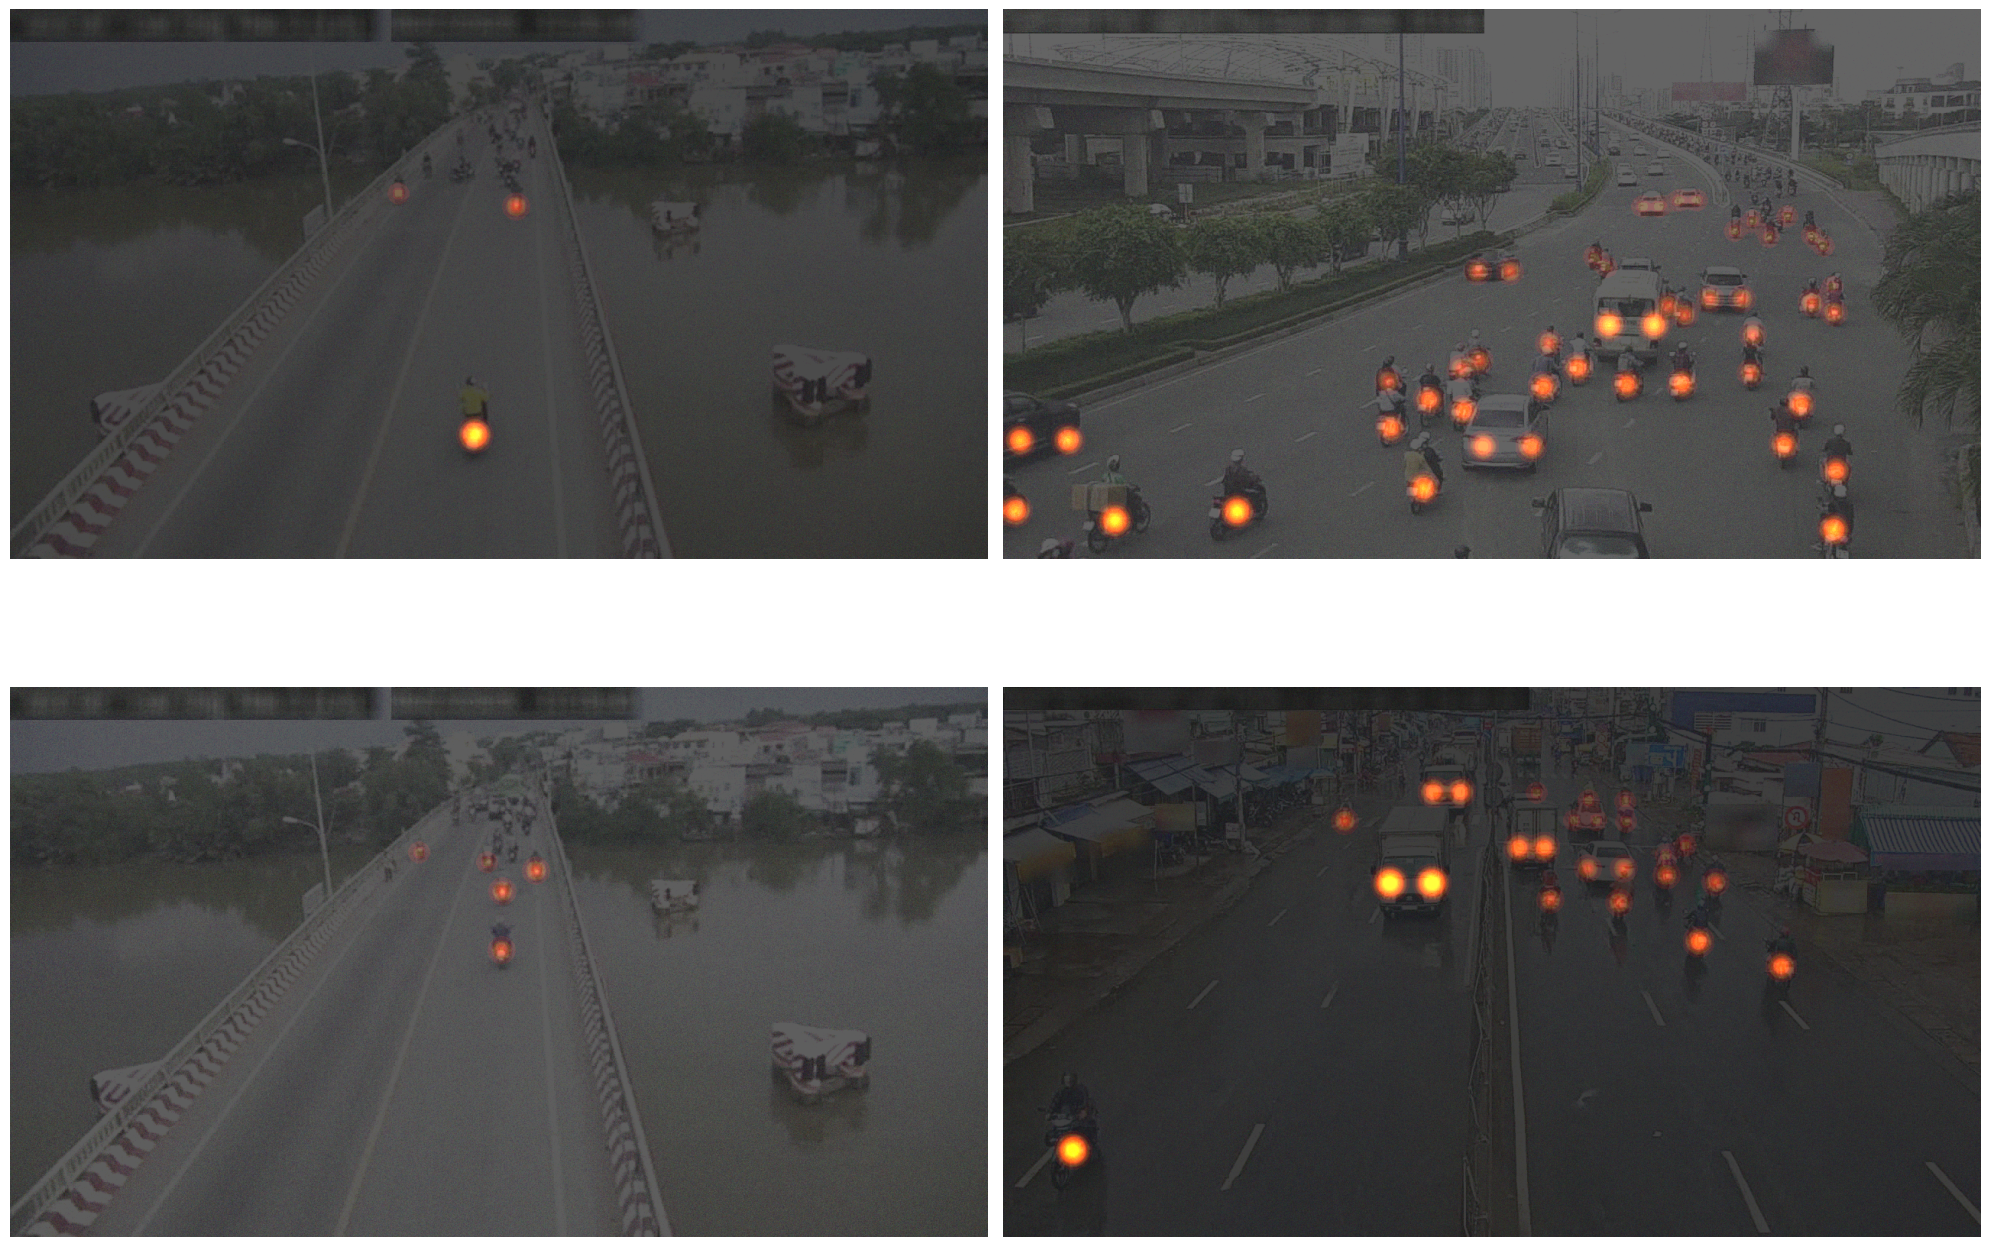

In [ ]:

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,15))
for ax in axes.flat:
  x = np.random.randint(0, len(annotations['day']) - 1)
  img = train_d2n.__getitem__(x)[0]
  img = F.to_image(img).permute(1,2,0).numpy()
  ax.imshow(img)
  ax.axis("off")

plt.tight_layout()